# Anomaly detection for temperature and pressure measurements

We attempt to use an Autoencoder with convolutional layers to detect anomalies in the temperature measurements. First, however, we consider the effects of changes in the temperature setpoints which introduces level shifts for two points in time. 

### Get dependencies and data

In [1]:
# import dependencies
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [87]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\reconstructions\\'

In [89]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.index = data.index.set_levels(
    levels=pd.to_datetime(data.index.get_level_values(3).values),
    level=3
)

In [90]:
# define X vars - we are only concerned with GH pressure and temperature
x_vars = [
    ('pressure', 'DC_GP101'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('setpoints', 'DC_GP101_default'),
    ('setpoints', 'TA01_GT10X_GM10X_default')
]

In [91]:
# filter columns to keep only x_vars
data = data[x_vars].copy()
print(data.columns)

print('\n\n Number of NAs\n')
print(data.isna().sum())

# remove NANs
data = data.dropna(
    how='any', 
    subset=x_vars
)

MultiIndex([(    'pressure',                 'DC_GP101'),
            ('temperatures',         'TA01_GT10X_GM10X'),
            (   'setpoints',         'DC_GP101_default'),
            (   'setpoints', 'TA01_GT10X_GM10X_default')],
           names=['category', 'sensor_ID'])


 Number of NAs

category      sensor_ID               
pressure      DC_GP101                    0
temperatures  TA01_GT10X_GM10X            0
setpoints     DC_GP101_default            0
              TA01_GT10X_GM10X_default    0
dtype: int64


## Accounting for setpoint changes

No. of unique vals for setpoints:
sensor_ID
DC_GP101_default            2
TA01_GT10X_GM10X_default    5
dtype: int64


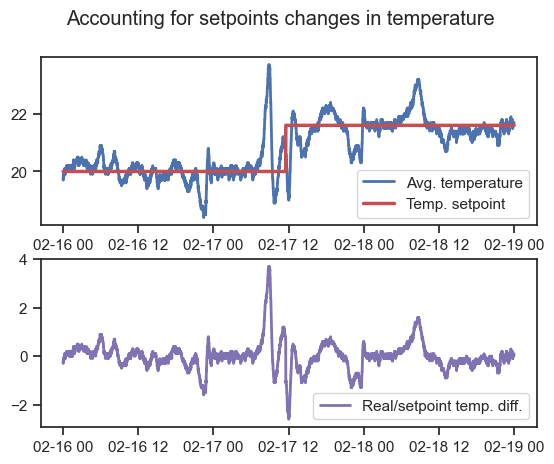

In [101]:
# indoor temp and indoor pressure is dependent on setpoints, 
# hence consider DIFF between setpoint and actual val for
# anomaly detection
print('No. of unique vals for setpoints:')
print(data.setpoints.nunique())

# create new cols w. diff
#data[('pressure', 'DC_GP101_diff')] = 0
data[('pressure', 'DC_GP101_diff')] = data[('pressure', 'DC_GP101')] - data[('setpoints', 'DC_GP101_default')]
data[('temperatures', 'TA01_GT10X_GM10X_diff')] = data[('temperatures', 'TA01_GT10X_GM10X')] - data[('setpoints', 'TA01_GT10X_GM10X_default')]

# plot differences f. last day
day = (2, (16, 17, 18))#, 18, 19, 20, 21))
subset = data.loc[day, :].droplevel(level=[0, 1, 2], axis=0).copy()

# set style
sns.set(style='ticks')

# get subplots (upper w. variable setpoint, lower w. accounted for)
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Accounting for setpoints changes in temperature')

# plot avg. temp and setpoints
ax1.plot(
    subset.temperatures.TA01_GT10X_GM10X, 
    linewidth=2.0, 
    alpha=1.0, 
    c='b',
    #marker='o',
    label='Avg. temperature'
)
ax1.plot(
    subset.setpoints.TA01_GT10X_GM10X_default, 
    linewidth=2.5,
    alpha=1.0, 
    c='r', 
    label='Temp. setpoint'
)
ax2.plot(
    subset.temperatures.TA01_GT10X_GM10X_diff, 
    linewidth=2.0, 
    alpha=1.0, 
    c='m', 
    label='Real/setpoint temp. diff.'
)

# get legends
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')

# get plot
plt.savefig(plot_path + 'setpoint.png')
plt.show()


### Accounting for erroneous setpoint observations

NameError: name 'data' is not defined

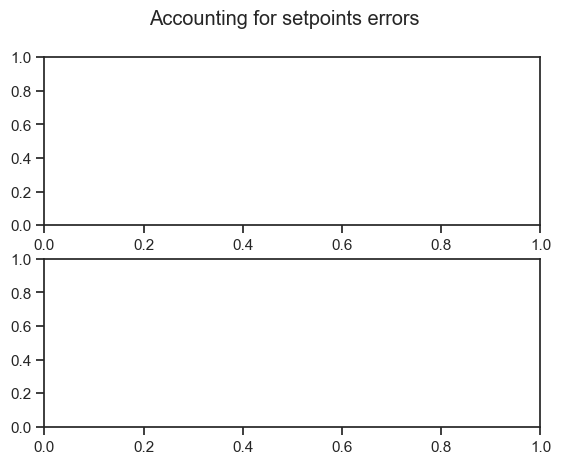

In [88]:
# also instances where setpoints have momentarily gone to zero. 
# display below.
# clearly erroneous?

# show setpoint errors)
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Accounting for setpoints errors')

# plot setpoonts errors
ax1.plot(
    data.setpoints.TA01_GT10X_GM10X_default.droplevel(level=[0, 1, 2], axis=0), 
    linewidth=2.0, 
    alpha=1.0, 
    c='r', 
    label='Temperature'
)
ax2.plot(
    data.setpoints.DC_GP101_default.droplevel(level=[0, 1, 2], axis=0), 
    linewidth=2.0, 
    alpha=1.0, 
    c='b', 
    label='Pressure'
)

# set ylims f. visibility
ax1.set_ylim(0, 25)
ax2.set_ylim(0, 8)

# get legends
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')

# get plot
plt.show()

In [8]:
### remove erroneous setpoint rows

data = data[
    (data.setpoints.TA01_GT10X_GM10X_default != 0.0) &
    (data.setpoints.DC_GP101_default != 0.0)
]

print('Minimum vals for setpoints:')
data.setpoints.min()

Minimum vals for setpoints:


sensor_ID
DC_GP101_default             4.0
TA01_GT10X_GM10X_default    20.0
dtype: float64

## Test AE on temperature data

We split data temporally, using data from December and January as training data, while testing on data in February.

In [9]:
def date_flagger(data, n_steps):
    # get flagged dates
    data['day'] = data.index.get_level_values(1).values
    data['date_flag'] = (data.day - data.day.shift(periods=n_steps)).apply(lambda val: abs(val) > 1)

    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['day'], data['date_flag']
    
    return flagged_idx

def data_split(data, n_steps, mean, std):
    """
    Split and whiten data. Using training mean and s.d. also for test data.
    """
    # get flagged dates, accounting for clipped 
    flags = date_flagger(
        data, 
        n_steps
    )
    
    # get numeric data
    dvals = (data.values - mean) / std
    n = len(data)
    
    # delete dataset
    del data
    
    # get all n_step-sequences from data series
    sequences = np.stack([
        dvals[i:i+n_steps] for i in range(n - n_steps)
    ]) 
    
    # get mask f. flags
    mask = [idx not in flags for idx in range(len(sequences))]
    sequences = sequences[mask]
    del mask
    
    # return sequences w. channel
    return sequences[..., np.newaxis]

In [10]:
# set N_STEPS
n_steps = 120

# mask f. train & test data
mask = data.index.get_level_values(0) == 2

# get train & test data
data_train = data[~mask][('temperatures', 'TA01_GT10X_GM10X_diff')].copy()
data_test  = data[mask][('temperatures', 'TA01_GT10X_GM10X_diff')].copy()

# delete original dataset & filtering mask
del data, mask

# get mean & std f. whitening
mean = np.mean(
    data_train.values, 
    axis=0
)

std  = np.std(
    data_train.values, 
    axis=0
)

# get tensors
X_train = data_split(data_train, n_steps=n_steps, mean=mean, std=std)
X_test = data_split(data_test, n_steps=n_steps, mean=mean, std=std)

# delete data sets
del data_train, data_test

C:\Users\Oskar\AppData\Local\Temp\ipykernel_61564\4233240456.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  flagged_idx = np.where(data.date_flag.values == 1)
C:\Users\Oskar\AppData\Local\Temp\ipykernel_61564\4233240456.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  flagged_idx = np.where(data.date_flag.values == 1)


### Define model

In [13]:
# define list w. layers
layerList = [
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    layers.Conv1D(
        filters=128, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    layers.Dropout(rate=0.4),
    layers.Conv1D(
        filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    layers.Conv1DTranspose(
        filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    layers.Dropout(rate=0.4),
    layers.Conv1DTranspose(
        filters=128, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

temp_model = keras.Sequential(layers=layerList, name='temp_model')
temp_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
temp_model.summary()

Model: "temp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 128)           1024      
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 64)            57408     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 60, 64)           28736     
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 120, 128)         57472     
 ranspose)                                              

### Train model

In [18]:
trainHist = temp_model.fit(
    X_train.astype(np.float64),
    X_train.astype(np.float64),
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

# get reconstructions and plot for test set
X_pred = temp_model.predict(X_test.astype(np.float64))


Epoch 1/20
702/702 [==============================] - 53s 73ms/step - loss: 0.0362 - val_loss: 0.0014
Epoch 2/20
702/702 [==============================] - 56s 79ms/step - loss: 0.0098 - val_loss: 0.0016
Epoch 3/20
702/702 [==============================] - 54s 77ms/step - loss: 0.0157 - val_loss: 0.0014
Epoch 4/20
702/702 [==============================] - 55s 79ms/step - loss: 0.0068 - val_loss: 0.0040
Epoch 5/20
702/702 [==============================] - 55s 78ms/step - loss: 0.0075 - val_loss: 0.0014
Epoch 6/20
702/702 [==============================] - 57s 81ms/step - loss: 0.0101 - val_loss: 0.0032
Epoch 7/20
702/702 [==============================] - 58s 83ms/step - loss: 0.0088 - val_loss: 0.0042
Epoch 8/20
702/702 [==============================] - 58s 82ms/step - loss: 0.0068 - val_loss: 0.0109
Epoch 9/20
702/702 [==============================] - 55s 78ms/step - loss: 0.0064 - val_loss: 0.0081
Epoch 10/20
702/702 [==============================] - 58s 82ms/step - loss: 0.006

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [19]:
X_pred = temp_model.predict(X_test.astype(np.float64))

1703/1703 [==============================] - 20s 12ms/step


### Visualize reconstruction

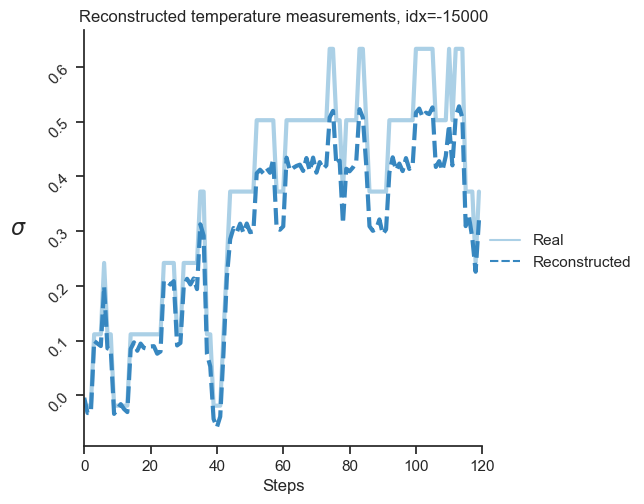

In [86]:
# set idx f. data
idx = -15000

# get plot data
plot_data = pd.DataFrame({
    'Real':X_test[idx][:, 0],
    'Reconstructed':X_pred[idx][:, 0],
})

sns.relplot(
    data=plot_data,
    kind='line',
    palette='Blues',
    linewidth=3.0,
    alpha=1.0,
    dashes=True,
    markers=False,
    legend='full',
)

# set title & legend
plt.title('Reconstructed temperature measurements, idx={}'.format(idx))
#plt.legend()

# set y-axis
plt.ylabel('$\sigma$', loc='center', rotation=0, fontsize=16, labelpad=20)
plt.yticks(rotation=45)
#plt.ylim(-5, 5)

# set x-axis
plt.xlim(0, n_steps)
plt.xlabel('Steps')
plt.savefig(fname=plot_path + 'temp_reconstruct_{}.png'.format(idx), dpi=500)

In [ ]:
# get MAE loss from training the AE
train_mae_loss = np.mean(np.abs(x_pred - x_train), axis=1)
test_mae_loss = np.mean(np.abs(x_pred_test - x_test), axis=1)

# set a threshold, roughly the maximum difference in standard deviations from the mean
#threshold = 1.0
threshold = np.max(train_mae_loss)

# get index and create temp dataset w. flags f. anomalies
idx = np.squeeze(np.array(test_mae_loss) > threshold)
temp = data[data.index.get_level_values(0) == 2].iloc[120:].copy()
temp['flag'] = idx

# groupby individual days and plot number of flagged observations
errs = temp.groupby(by=['month', 'day'])['flag'].sum()

# print "anomaly" dates:
print('By setting the threshold to {:.2f} s.d., we get the following flagged dates:'.format(threshold))
errs[errs > 0]

## Test AE on pressure data

We split data temporally, using data from December and January as training data, while testing on data in February. Using same architecture as for temperature model, i.e. 128-64-Z-64-128. 

In [ ]:
x_train, x_test = data_split(
    data=data,
    var=('pressure', 'DC_GP101')
)

pressure_model = keras.Sequential(layers=layerList, name='pressure_model')
pressure_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
pressure_model.summary()

trainHist = pressure_model.fit(
    x_train,
    x_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

x_predTrain = pressure_model.predict(x_train)
x_predicted = pressure_model.predict(x_test)

In [ ]:
# plot for test set
plt.plot(x_predicted[-1], label='reconstructed', c='b', alpha=0.5, linewidth=3.0)
plt.plot(x_test[-1], label='real', c='r', alpha=1.0, linewidth=1.0)

plt.title('Reconstructed pressure measurements')
plt.ylabel('$\sigma$')
plt.xlim(0, 120)
#plt.ylim(-4, 4)
plt.legend(loc='upper left')
plt.savefig(fname=plot_path + 'press_reconstructed_2.png', dpi=500)

In [ ]:
# get MAE loss from training the AE
train_mae_loss = np.mean(np.abs(x_predTrain - x_train), axis=1)
test_mae_loss = np.mean(np.abs(x_predicted - x_test), axis=1)

# set a threshold, roughly the maximum difference in standard deviations from the mean
#threshold = 1.0
threshold = np.max(train_mae_loss)

# get index and create temp dataset w. flags f. anomalies
idx = np.squeeze(np.array(test_mae_loss) > threshold)
temp = data[data.index.get_level_values(0) == 2].iloc[120:].copy()
temp['flag'] = idx

# groupby individual days and plot number of flagged observations
errs = temp.groupby(by=['month', 'day'])['flag'].sum()

# print "anomaly" dates:
print('By setting the threshold to {:.2f} s.d., we get the following flagged dates:'.format(threshold))
errs[errs > 0]